# Analysis of Precipitation Patterns in the Pacific Ocean
Orain Water, an innovative start-up focused on rainwater collection over maritime areas, is keen on identifying regions within the Pacific Ocean that experience the highest levels of precipitation. This report is dedicated to analyzing and pinpointing these areas of maximum rainfall, leveraging comprehensive meteorological data and advanced analytical techniques. Our goal is to provide Orain Water with precise and actionable insights to optimize their rainwater collection strategy.

## Data Collection

The NASA POWER (Prediction of Worldwide Energy Resource) data service provides an extensive collection of meteorological and solar data, which can be harnessed for various applications, including our precipitation prediction tool.

First importing the necessary libraries:

In [1]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, requests
import numpy as np


# Fetching Weather Data from NASA POWER API
The NASA POWER (Prediction Of Worldwide Energy Resource) project provides global meteorological data, which can be leveraged for various applications including weather predictions, climate studies, and more.

In this section, we define a Python function named get_weather_data. The function's primary role is to fetch weather data based on specified latitude and longitude, and other optional parameters.
## Purpose: 
To fetch and return weather data from the NASA POWER API based on the given coordinates and parameters.

### Inputs:

latitude (float): The latitude of the desired location.
longitude (float): The longitude of the desired location.
parameters (str, optional): A comma-separated list of weather parameters to fetch. Defaults include temperature, dew point, and precipitation among others.
start_time (str, optional): The start date for fetching data in YYYYMMDD format.
end_time (str, optional): The end date for fetching data in YYYYMMDD format.

In [2]:
def get_weather_data(latitude, longitude, 
                     parameters='T2M,T2MDEW,T2MWT,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PRECTOTCORR',
                     start_time='20000101', 
                     end_time='20230101'):
    """
    Fetch weather data from NASA POWER API for the specified latitude, longitude, and parameters.

    Parameters:
    - latitude (float): Latitude of the location
    - longitude (float): Longitude of the location
    - parameters (str): Comma-separated list of weather parameters to fetch
    - start_time (str): Start date in YYYYMMDD format
    - end_time (str): End date in YYYYMMDD format

    Returns:
    - pd.DataFrame: A DataFrame containing the fetched weather data
    """
    
    # Construct the API request URL
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    query_parameters = {
        'parameters': parameters,
        'community': 'RE',
        'longitude': longitude,
        'latitude': latitude,
        'start': start_time,
        'end': end_time,
        'format': 'JSON'
    }
    api_request_url = f"{base_url}?{'&'.join([f'{key}={value}' for key, value in query_parameters.items()])}"

    try:
        # Make the GET request to the POWER API
        response = requests.get(url=api_request_url, verify=True, timeout=30.00)
        response.raise_for_status()  # Raise an HTTPError if the HTTP request returned an unsuccessful status code

        # Parse the JSON response content
        content = response.json()
        
        # Ensure the response contains the required data
        if "properties" in content and "parameter" in content["properties"]:
            data = content["properties"]["parameter"]
            # Convert the data to a Pandas DataFrame and return it
            df = pd.DataFrame(data)
            # Convert the index to a proper date format
            df.index = pd.to_datetime(df.index)
            return df
        else:
            print("Error: Missing data in API response.")
            return None

    except requests.RequestException as e:
        print(f"Error fetching data from NASA POWER API: {e}")
        return None


Our initial analysis centers on a specific set of GPS coordinates situated in the Pacific Ocean, to the west of Central America. In the dataset under examination, "T2M" represents the air temperature recorded 2 meters above sea level, expressed in degrees Celsius. Additionally, "PRECTOTCORR" refers to the total corrected precipitation, measured in millimeters. This preliminary focus will lay the groundwork for our broader investigation into the region's climatic patterns.

In [3]:
latitude, longitude = 10, -130
df = get_weather_data(latitude, longitude,parameters='T2M,PRECTOTCORR')

df.head()

,T2M,PRECTOTCORR
2000-01-01,24.62,3.83
2000-01-02,24.21,5.80
2000-01-03,23.91,4.85
2000-01-04,23.68,1.95
2000-01-05,23.41,16.68


In [4]:
df.describe()

,T2M,PRECTOTCORR
count,8402.000000,8402.000000
mean,26.411951,7.981082
std,0.849176,10.803025
min,23.050000,0.000000
25%,25.910000,1.130000
50%,26.510000,4.130000
75%,27.010000,10.807500
max,28.900000,166.340000


Let's look at the histograms of these features:

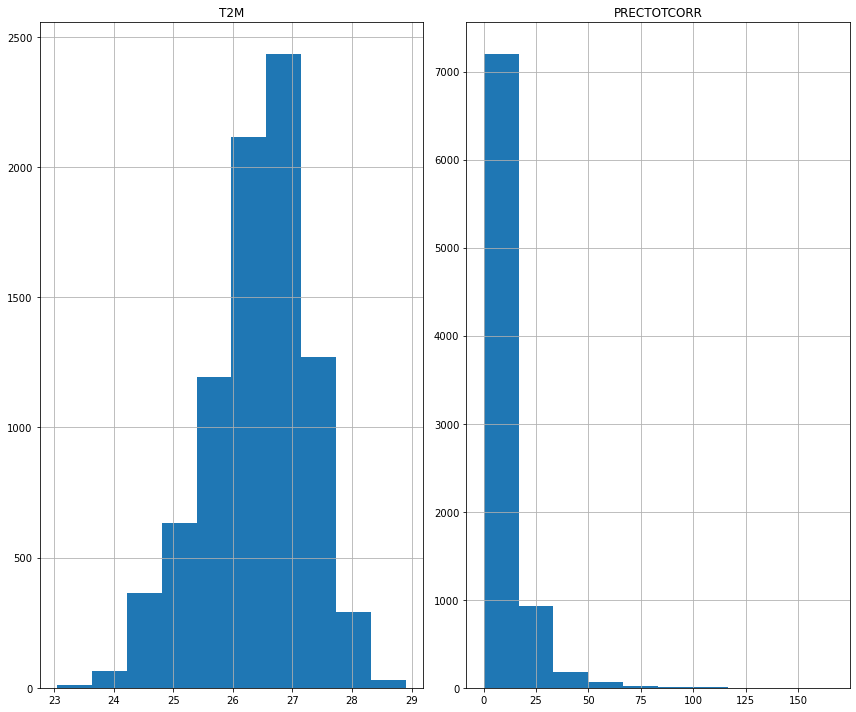

In [5]:
df.hist(figsize=(12, 10))
plt.tight_layout()

The temperature data exhibits a Gaussian (normal) distribution pattern, whereas the precipitation data more closely aligns with a Poisson distribution.

## Time series plot

Text(0.5, 0, 'Year')

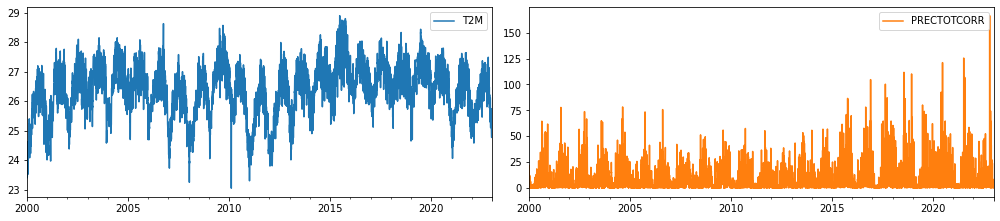

In [22]:
df.plot(subplots=True, layout=(4,2), figsize=(14,12), sharex=False)
plt.tight_layout()



Upon examining the time series plots, the seasonal variations in both temperature and precipitation are evident. In addition to these seasonal patterns, there are notable long-term fluctuations in temperature. For instance, the data indicates a temperature minimum around 2010, with a peak occurring around 2016. A similar trend is observable in the precipitation time series, reflecting these long-term changes.

## Average Temperature and Precipitation:

Let's look at the average temperature and precipitation over these years near Vancouver's west coast.


In [8]:
mean_aggregate = df.groupby([df.index.month, df.index.day]).mean()

In [9]:
mean_aggregate.describe()

,T2M,PRECTOTCORR
count,366.000000,366.000000
mean,26.409937,7.966990
std,0.545620,4.364989
min,25.310870,0.868333
25%,25.897935,4.062283
50%,26.651739,7.632609
75%,26.860761,11.439348
max,27.157826,21.091304


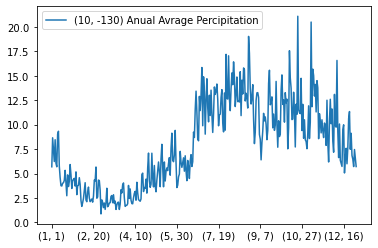

In [10]:
mean_aggregate['PRECTOTCORR'].plot()
plt.legend([f"{latitude, longitude} Anual Avrage Percipitation"])

This indicates that precipitation is at its lowest in March, begins to rise in July, and reaches its peak in November.

We are interested in finding a location where most of the precipitation falls in the form of rain. Therefore, we will pursue the following strategy: For example along a fixed longitude of -130 degrees, which is close to the west coast, we will choose multiple points with different longitude and measure the amount of precipitation at each one. For the longitude range, we will consider -90 to 90 degrees. Let's define a function, average_rain, that calculates the total precipitation per year for a given location:


In [13]:
def average_rain(latitude, longitude):
    # this function calculates the total percipitation for a given gps location
    df = get_weather_data(latitude, longitude, parameters='T2M,PRECTOTCORR')
    mean_aggregate = df.groupby([df.index.month, df.index.day]).mean()
    return mean_aggregate['PRECTOTCORR'].sum()

Now we calculate the total percipitation along a fixed logitude line.

In [20]:
latitudes= range(-90, 90, 5)

# Near west cost, Vancouver
longitude = -130
rain_latitude = np.zeros((2, len(latitudes)))
for index, lat in enumerate(latitudes):
#     print(index, lat)
    rain_latitude[0, index] = lat
    rain_latitude[1, index] = average_rain(lat, longitude)

Text(0, 0.5, 'Percipitation aggregate (mm)')

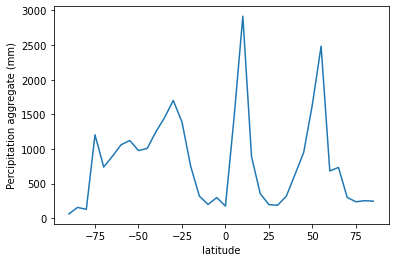

In [25]:
plt.plot(rain_latitude[0,:], rain_latitude[1,:])
plt.xlabel("Latitude")
plt.ylabel("Percipitation aggregate (mm)")


It is interesting to see that near the equator there is not much rainfall. We are interested in those latitudes where rainfall is at its peak namely around 10 and 50 latitiudes. Now let's look at multiple longitudes and compare them.

In [26]:
latitudes= range(-70, 70, 5)
df_all = pd.DataFrame(index=latitudes)

for longitude in range(-180, -125, 5):
    rain_latitude = np.zeros(len(latitudes))
    for index, lat in enumerate(latitudes):
#         print(index, lat, longitude)
    #     print(index, lat)
    
        rain_latitude[index] = average_rain(lat, longitude)
#     print(longitude)
    df_all[longitude] = rain_latitude 

Text(0, 0.5, 'Percipitation aggregate (mm)')

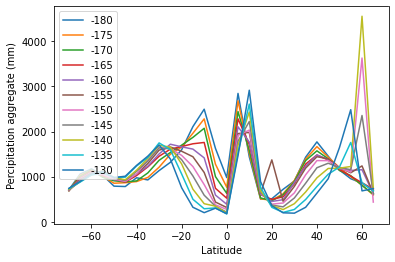

In [27]:
df_all.plot()
plt.xlabel("Latitude")
plt.ylabel("Percipitation aggregate (mm)")

The graph above illustrates the average rainfall distribution across various longitudes. It appears that regions closer to the equator generally receive the highest amount of rainfall. Additionally, at longitudes such as -140 and -150, there is also significant rainfall occurring at a latitude of approximately 60 degrees.